#Dataset1-Big(85282 rows)

##Import Dataset

In [1]:
import pandas as pd;

#Loading dataset and rename columns

df=pd.read_excel("healthtapQAs_v1.xlsx");
df.columns=["questions","answers"];

df

,questions,answers
0,zirconium dental implants. how common is it us...,a majority of the dental implants placed are t...
1,zoloft/ sertaline cause heart racing can't sit...,check with your doc could be side effect of th...
2,zoloft (sertraline) side effects? does it make...,it can be related to either weight gain or los...
3,yellow skin around wound from cat bite. why?,this may be the secondary result of a resolvin...
4,yeast infection and open sores major swelling ...,bathing in a bath with baking soda may help de...
...,...,...
85277,what is the best: a conventional angiography o...,for small vessels conventional angiography is ...
85278,what is unique about taking medicine every 24 ...,try taking one half tab every day. but 10mg si...
85279,what treat should be of following sypmtoms pai...,your description of the pain sounds neuropathi...
85280,can you explain incomplete right bundle branch...,the righty and left ventricles are induced to ...


##Data Preprocessing

In [2]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords

#keeping only words in the sentence and removing punctuations.

def clean_sentence(sentence, stopwords=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)

    
    if stopwords:
         sentence = remove_stopwords(sentence)
    

    
    return sentence
                    
def get_cleaned_sentences(df,stopwords=False):    
    sents=df[["questions"]];
    cleaned_sentences=[]

    for index,row in df.iterrows():
        #print(index,row)
        cleaned=clean_sentence(row["questions"],stopwords);
        cleaned_sentences.append(cleaned);
    return cleaned_sentences;

cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
#print(cleaned_sentences);

print("\n")

cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
#print(cleaned_sentences_with_stopwords[0]);

In [3]:
print(cleaned_sentences_with_stopwords[0]);

zirconium dental implants how common is it used now is there any advantages or benefits over titanium implants cons  pros please thanks


##Word2Vec-Skipgram Model

In [4]:
from gensim.models import Word2Vec 
import gensim.downloader as api

#loading Word2vec google news pretrained model  
v2w_model=None;
try:
    v2w_model = gensim.models.KeyedVectors.load("./w2vecmodel.mod")
    print("Loaded saved W2V model")
except:            
    v2w_model = api.load('word2vec-google-news-300')
    v2w_model.save("./w2vecmodel.mod")
    print("Downloaded and saved glove model")

w2vec_embedding_size=len(v2w_model['computer']);

[=================================================-] 98.6% 1639.0/1662.8MB downloaded
Downloaded and saved glove model


In [5]:
#creating vectors
def getWordVec(word,model):
        samp=model['computer'];
        vec=[0]*len(samp);
        try:
                vec=model[word];
        except:
                vec=[0]*len(samp);
        return (vec)


def getPhraseEmbedding(phrase,embeddingmodel):
                       
        samp=getWordVec('computer', embeddingmodel);
        vec=numpy.array([0]*len(samp));
        den=0;
        for word in phrase.split():
            #print(word)
            den=den+1;
            vec=vec+numpy.array(getWordVec(word,embeddingmodel));

        return vec.reshape(1, -1)

In [6]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
#finding cosine similarity from vectors
def retrieveAndPrintFAQAnswer(question_embedding,sentence_embeddings,FAQdf,sentences):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
        #sim=cosine_similarity(embedding.reshape(1, -1),question_embedding.reshape(1, -1))[0][0];
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        print(index, sim, sentences[index])
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
    print("\n")
    print("Question: ",question)
    print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    print(FAQdf.iloc[index_sim,1]) 

In [7]:
question_orig="How to keep good health?"
#question_orig=input()
question=clean_sentence(question_orig,stopwords=False);

In [8]:
#With w2Vec
import numpy
sent_embeddings=[];
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

question_embedding=getPhraseEmbedding(question,v2w_model);

retrieveAndPrintFAQAnswer(question_embedding,sent_embeddings,df, cleaned_sentences);

Streaming output truncated to the last 5000 lines.
80289 0.20928023309618934 midsternal chest pain lead
80290 0.3316712893725098 emergency room high blood pressure
80291 0.24825092738587393 mean systolic diastolic blood pressure readings close number 11090
80292 0.16744572408209826 difference benicar olmesartan hct losartan hctz
80293 0.35334509139711423 head dizzy spell short breath mean
80294 0.2216197318241221 heartbeat machine called
80295 0.3479716737354793 mean left womans chest sore
80296 0.41072170093795024 whats average blood pressure for12 year olds
80297 0.3882025319350515 vitamin help reduce ldl
80298 0.3545073487266655 causes constant passing feaces meal remedied
80299 0.3492339020826134 makes peritonitis pleurisy pericarditis cause great deal pain
80300 0.29227626546541013 borderline inferior q wave mean
80301 0.30039347498523555 concerns acetaminophen ibuprofen liver effects safer aspirin inflammation headache pericarditis
80302 0.1111448047328466 definition description 

#Implementing Chatbot using Word2Vec

In [9]:
#embedding the exsiting dataset
sent_embeddings=[];
for sent in cleaned_sentences:
  sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

In [10]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
import numpy
import time

print("Welcome to the Question Answering System")      

while True:
  print("Question:") 
  
  question_orig=input()
  
  if (question_orig.lower()=='quit'):
    break
  measure1 = time.time()
  question=clean_sentence(question_orig,stopwords=False);
  


  question_embedding=getPhraseEmbedding(question,v2w_model);  
  def retrieveAndPrintFAQAnswer(question_embedding,sentence_embeddings,FAQdf,sentences):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
      sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim;
        index_sim=index;
    #print("\n")
    #print("Question: ",question)
    #print("\n");
    #print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    #print(FAQdf.iloc[index_sim,1]) 
    print("Answer:",FAQdf.iloc[index_sim,1])
    print("----------------------")
    measure2 = time.time()
    print("Response Time",measure2 - measure1)
    print("----------------------")
    print("\n");
    print("Enter Quit to exit: ")
  retrieveAndPrintFAQAnswer(question_embedding,sent_embeddings,df, cleaned_sentences);




print("----------------------")
print("Thank You")
print("----------------------")

Welcome to the Question Answering System
Question:
How to remain healthy?
Answer: the best way to lose weight is to eat less while eating a balanced diet. that means fruits vegetables whole grains and lean protein. for fats use oils like olive and canola. cut down on foods with added calories from sugar. it's also helpful to have support from family members and friends. for more info check out <link>
----------------------
Response Time 18.334087133407593
----------------------


Enter Quit to exit: 
Question:
How to eat which keeps us healthy for longer time?
Answer: i would recommend a healthy high protein low carb low glycemic diet. make sure you eat adequate protein before trying to exercise. your weakness experienced when you exercise may be from improper intake of food before exercise. start slow with exercise even just walking 20 minutes a day then build from there.
----------------------
Response Time 18.08911895751953
----------------------


Enter Quit to exit: 
Question:
Qui

In [ ]:
#With Glove

sent_embeddings=[];
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,glove_model));
    
question_embedding=getPhraseEmbedding(question,glove_model);

retrieveAndPrintFAQAnswer(question_embedding,sent_embeddings,df, cleaned_sentences);

#Dataset2-Easy

##Import Dataset

In [11]:
import pandas as pd;

#Loading dataset and renaming columns

df=pd.read_csv("FAQ_standard.csv");
df.columns=["questions","answers","AnswerCode"];

df

,questions,answers,AnswerCode
0,What does the job hunting experience look like ?,Job hunting experience involves networking to ...,1
1,Any insights you can offer about the DS job ma...,"There are many kinds of roles, data scientist,...",2
2,What's the impact of Covid on hiring for DS ro...,Hiring is going to slow down. First in small c...,3
3,What skills and qualities do employers look fo...,The following are some skills employers usuall...,4
4,Do employers look for an advanced ML degree?,For more senior roles: People typically look f...,5
5,How does a typical day of a data scientist loo...,Here are some tasks in the typical day of a da...,6
6,Is preparation of algorithms and data structur...,Yes. In many data science interviews (ML Scien...,7
7,What is the mathematical background required t...,The following three are the basic building blo...,8
8,What are the various rounds in a data scientis...,Usually the data science interview has a subse...,9
9,What level of proficiency is needed for a data...,"Needs to be reasonably proficient. Again, a da...",10


In [12]:
import pandas as pd;

#Load dataset and rename columns

df_test=pd.read_excel("FAQ_test_Easy.xlsx")
df_test.columns=["questions","ActualCode","PredictedCode","Prediction?","ActualQuestion","PredictedQuestion"]

df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How is the job searching experience nowadays?,1,NaN,NaN,What does the job hunting experience look like ?,NaN
1,"How are the DS jobs on the market, please?",2,NaN,NaN,Any insights you can offer about the DS job ma...,NaN
2,How is DS hiring impacted due to Covid?,3,NaN,NaN,What's the impact of Covid on hiring for DS ro...,NaN
3,In a data scientist what qualifications and at...,4,NaN,NaN,What skills and qualities do employers look fo...,NaN
4,Are employers looking for an advanced ML degree?,5,NaN,NaN,Do employers look for an advanced ML degree?,NaN
5,On a typical day what does a data scientist do?,6,NaN,NaN,How does a typical day of a data scientist loo...,NaN
6,Do we need to study algorithms for a data scie...,7,NaN,NaN,Is preparation of algorithms and data structur...,NaN
7,What is the mathematical background needed to ...,8,NaN,NaN,What is the mathematical background required t...,NaN
8,How many rounds of interview are in a data sc...,9,NaN,NaN,What are the various rounds in a data scientis...,NaN
9,How proficient a data scientist has to be in c...,10,NaN,NaN,What level of proficiency is needed for a data...,NaN


##Data Preprocessing

In [13]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords


def clean_sentence(sentence, stopwords=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)

    
    if stopwords:
         sentence = remove_stopwords(sentence)
    
    
    return sentence
                    
def get_cleaned_sentences(tf,stopwords=False):    
    sents=tf[["questions"]];
    cleaned_sentences=[]

    for index,row in tf.iterrows():
        #print(index,row)
        cleaned=clean_sentence(row["questions"],stopwords);
        cleaned_sentences.append(cleaned);
    return cleaned_sentences;

cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
print(cleaned_sentences);

print("\n")

cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
print(cleaned_sentences_with_stopwords);

['job hunting experience look like', 'insights offer ds job market', 'whats impact covid hiring ds roles', 'skills qualities employers look data scientist', 'employers look advanced ml degree', 'typical day data scientist look like', 'preparation algorithms data structures needed data science interview', 'mathematical background required data scientist', 'rounds data scientist interview', 'level proficiency needed data scientist coding']


['what does the job hunting experience look like ', 'any insights you can offer about the ds job market ', 'whats the impact of covid on hiring for ds roles', 'what skills and qualities do employers look for in a data scientist', 'do employers look for an advanced ml degree', 'how does a typical day of a data scientist look like', 'is preparation of algorithms and data structures needed for a data science interview ', 'what is the mathematical background required to be a data scientist ', 'what are the various rounds in a data scientist interview ', 

In [14]:
print(cleaned_sentences_with_stopwords[0]);

what does the job hunting experience look like 


##Word2Vec-Skipgram Model

In [15]:
from gensim.models import Word2Vec 
import gensim.downloader as api

    
v2w_model=None;
try:
    v2w_model = gensim.models.KeyedVectors.load("w2vecmodel.mod")
    print("Loaded w2v model")
except:            
    v2w_model = api.load('word2vec-google-news-300')
    v2w_model.save("w2vecmodel.mod")
    print("Saved w2v model")

w2vec_embedding_size=len(v2w_model['computer']);

Loaded w2v model


In [16]:
#question_orig="What does a data scientist usually do ?"
#question_orig=input()
#question=clean_sentence(question_orig,stopwords=False);
cleaned_sentences_test=get_cleaned_sentences(df_test,stopwords=False)
print(cleaned_sentences_test);

['how is the job searching experience nowadays', 'how are the ds jobs on the market please', 'how is ds hiring impacted due to covid', 'in a data scientist what qualifications and attributes do employers look for', 'are employers looking for an advanced ml degree', 'on a typical day what does a data scientist do', 'do we need to study algorithms for a data science interview', 'what is the mathematical background needed to be a data scientist ', 'how many rounds of interview are in a data science interview ', 'how proficient a data scientist has to be in coding']


In [17]:
def getWordVec(word,model):
        samp=model['computer'];
        vec=[0]*len(samp);
        try:
                vec=model[word];
        except:
                vec=[0]*len(samp);
        return (vec)


def getPhraseEmbedding(phrase,embeddingmodel):
                       
        samp=getWordVec('computer', embeddingmodel);
        vec=numpy.array([0]*len(samp));
        den=0;
        for word in phrase.split():
            #print(word)
            den=den+1;
            vec=vec+numpy.array(getWordVec(word,embeddingmodel));
        #vec=vec/den;
        #return (vec.tolist());
        return vec.reshape(1, -1)

In [18]:
#With w2Vec for original question dataset
import numpy
sent_embeddings=[];
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

In [19]:
#With w2Vec for test question dataset
import numpy
sent_embeddings_test=[];
for sent_test in cleaned_sentences_test:
    sent_embeddings_test.append(getPhraseEmbedding(sent_test,v2w_model));

In [20]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
def retrieveAndPrintFAQAnswer(question_embeddings_test,sentence_embeddings,FAQdf,sentences,FAQdf_test,sentences_test):
  for index_test,faq_embedding_test in enumerate(question_embeddings_test):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
        
      sim=cosine_similarity(faq_embedding,faq_embedding_test)[0][0];
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim;
        index_sim=index;

    FAQdf_test.iloc[index_test,2]=FAQdf.iloc[index_sim,2]
    FAQdf_test.iloc[index_test,5]=FAQdf.iloc[index_sim,0]
    print("\n")
    print("Question: ",sentences_test[index_test])
    print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    print("Answer:",FAQdf.iloc[index_sim,1])        
  df_test=FAQdf_test 
retrieveAndPrintFAQAnswer(sent_embeddings_test,sent_embeddings,df,cleaned_sentences,df_test,cleaned_sentences_test);



Question:  how is the job searching experience nowadays


Retrieved:  What does the job hunting experience look like ?
Answer: Job hunting experience involves networking to get in touch with the right people in various companies, applying to lots of jobs through various channels, preparing for interviews – while interviews are uncertain it is necessary to prepare well what you CAN prepare, smart scheduling of interviews to get the best job and salary you can.


Question:  how are the ds jobs on the market please


Retrieved:  Any insights you can offer about the DS job market ?
Answer: There are many kinds of roles, data scientist, analyst, data engineer and so on. There are many levels of companies. In smaller companies the roles are usually combined into one while in larger companies there are more nuanced roles. Since more and more companies are just getting started on their data journey, the overall demand is expected to increase in the next few years.


Question:  how is ds hiri

In [21]:
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How is the job searching experience nowadays?,1,1.0,NaN,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,"How are the DS jobs on the market, please?",2,2.0,NaN,Any insights you can offer about the DS job ma...,Any insights you can offer about the DS job ma...
2,How is DS hiring impacted due to Covid?,3,3.0,NaN,What's the impact of Covid on hiring for DS ro...,What's the impact of Covid on hiring for DS ro...
3,In a data scientist what qualifications and at...,4,4.0,NaN,What skills and qualities do employers look fo...,What skills and qualities do employers look fo...
4,Are employers looking for an advanced ML degree?,5,5.0,NaN,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,On a typical day what does a data scientist do?,6,6.0,NaN,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,Do we need to study algorithms for a data scie...,7,7.0,NaN,Is preparation of algorithms and data structur...,Is preparation of algorithms and data structur...
7,What is the mathematical background needed to ...,8,8.0,NaN,What is the mathematical background required t...,What is the mathematical background required t...
8,How many rounds of interview are in a data sc...,9,9.0,NaN,What are the various rounds in a data scientis...,What are the various rounds in a data scientis...
9,How proficient a data scientist has to be in c...,10,10.0,NaN,What level of proficiency is needed for a data...,What level of proficiency is needed for a data...


In [22]:
for i in range(df_test.shape[0]):
 if df_test.iloc[i,1]!=df_test.iloc[i,2]:
   df_test.iloc[i,3]='InCorrect'
 else:
   df_test.iloc[i,3]='correct'
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How is the job searching experience nowadays?,1,1.0,correct,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,"How are the DS jobs on the market, please?",2,2.0,correct,Any insights you can offer about the DS job ma...,Any insights you can offer about the DS job ma...
2,How is DS hiring impacted due to Covid?,3,3.0,correct,What's the impact of Covid on hiring for DS ro...,What's the impact of Covid on hiring for DS ro...
3,In a data scientist what qualifications and at...,4,4.0,correct,What skills and qualities do employers look fo...,What skills and qualities do employers look fo...
4,Are employers looking for an advanced ML degree?,5,5.0,correct,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,On a typical day what does a data scientist do?,6,6.0,correct,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,Do we need to study algorithms for a data scie...,7,7.0,correct,Is preparation of algorithms and data structur...,Is preparation of algorithms and data structur...
7,What is the mathematical background needed to ...,8,8.0,correct,What is the mathematical background required t...,What is the mathematical background required t...
8,How many rounds of interview are in a data sc...,9,9.0,correct,What are the various rounds in a data scientis...,What are the various rounds in a data scientis...
9,How proficient a data scientist has to be in c...,10,10.0,correct,What level of proficiency is needed for a data...,What level of proficiency is needed for a data...


In [23]:
list_data_answers=df_test.ActualCode.values.tolist()
list_data_FoundCode=df_test.PredictedCode.values.tolist()

In [24]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
multilabel_confusion_matrix(list_data_answers, list_data_FoundCode)
#tn, fp, fn, tp = confusion_matrix([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0, 2.0, 2.0, 10.0, 4.0, 1.0, 2.0, 1.0, 2.0, 2.0]).ravel()
#print(metrics.classification_report(list_data_answers, list_data_FoundCode))

array([[[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]]])

In [25]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix


cm = confusion_matrix(list_data_answers, list_data_FoundCode, binary=False)

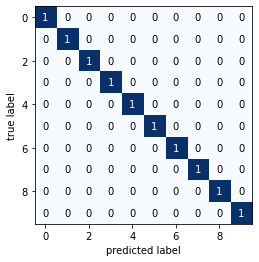

In [26]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pprint
#creating confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [27]:
print(metrics.classification_report(list_data_answers, list_data_FoundCode))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



#Dataset3-Medium

##Import Dataset

In [28]:
import pandas as pd;

#Loading dataset and renaming columns

df=pd.read_csv("FAQ_standard.csv");
df.columns=["questions","answers","AnswerCode"];

df

,questions,answers,AnswerCode
0,What does the job hunting experience look like ?,Job hunting experience involves networking to ...,1
1,Any insights you can offer about the DS job ma...,"There are many kinds of roles, data scientist,...",2
2,What's the impact of Covid on hiring for DS ro...,Hiring is going to slow down. First in small c...,3
3,What skills and qualities do employers look fo...,The following are some skills employers usuall...,4
4,Do employers look for an advanced ML degree?,For more senior roles: People typically look f...,5
5,How does a typical day of a data scientist loo...,Here are some tasks in the typical day of a da...,6
6,Is preparation of algorithms and data structur...,Yes. In many data science interviews (ML Scien...,7
7,What is the mathematical background required t...,The following three are the basic building blo...,8
8,What are the various rounds in a data scientis...,Usually the data science interview has a subse...,9
9,What level of proficiency is needed for a data...,"Needs to be reasonably proficient. Again, a da...",10


In [29]:
import pandas as pd;

#Load dataset and rename columns

df_test=pd.read_excel("FAQ_test_Medium.xlsx")
df_test.columns=["questions","ActualCode","PredictedCode","Prediction?","ActualQuestion","PredictedQuestion"]

df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How does job searching experience would look?,1,NaN,NaN,What does the job hunting experience look like ?,NaN
1,Please provide how DS jobs are in the market?,2,NaN,NaN,Any insights you can offer about the DS job ma...,NaN
2,How has the Covid impacted DS hiring?,3,NaN,NaN,What's the impact of Covid on hiring for DS ro...,NaN
3,What skills do employers want from data scienc...,4,NaN,NaN,What skills and qualities do employers look fo...,NaN
4,Is advanced degree in ML required?,5,NaN,NaN,Do employers look for an advanced ML degree?,NaN
5,What data scientist do in a typical day?,6,NaN,NaN,How does a typical day of a data scientist loo...,NaN
6,For an interview in data science are we requir...,7,NaN,NaN,Is preparation of algorithms and data structur...,NaN
7,What is the mathematical background required t...,8,NaN,NaN,What is the mathematical background required t...,NaN
8,How many rounds of interview are required to c...,9,NaN,NaN,What are the various rounds in a data scientis...,NaN
9,How much proficient a data scientist should be...,10,NaN,NaN,What level of proficiency is needed for a data...,NaN


##Data Preprocessing

In [30]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords


def clean_sentence(sentence, stopwords=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)

    
    if stopwords:
         sentence = remove_stopwords(sentence)
    
    
    return sentence
                    
def get_cleaned_sentences(tf,stopwords=False):    
    sents=tf[["questions"]];
    cleaned_sentences=[]

    for index,row in tf.iterrows():
        #print(index,row)
        cleaned=clean_sentence(row["questions"],stopwords);
        cleaned_sentences.append(cleaned);
    return cleaned_sentences;

cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
print(cleaned_sentences);

print("\n")

cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
print(cleaned_sentences_with_stopwords);

['job hunting experience look like', 'insights offer ds job market', 'whats impact covid hiring ds roles', 'skills qualities employers look data scientist', 'employers look advanced ml degree', 'typical day data scientist look like', 'preparation algorithms data structures needed data science interview', 'mathematical background required data scientist', 'rounds data scientist interview', 'level proficiency needed data scientist coding']


['what does the job hunting experience look like ', 'any insights you can offer about the ds job market ', 'whats the impact of covid on hiring for ds roles', 'what skills and qualities do employers look for in a data scientist', 'do employers look for an advanced ml degree', 'how does a typical day of a data scientist look like', 'is preparation of algorithms and data structures needed for a data science interview ', 'what is the mathematical background required to be a data scientist ', 'what are the various rounds in a data scientist interview ', 

In [31]:
print(cleaned_sentences_with_stopwords[0]);

what does the job hunting experience look like 


##Word2Vec-Skipgram Model

In [32]:
from gensim.models import Word2Vec 
import gensim.downloader as api

    
v2w_model=None;
try:
    v2w_model = gensim.models.KeyedVectors.load("w2vecmodel.mod")
    print("Loaded w2v model")
except:            
    v2w_model = api.load('word2vec-google-news-300')
    v2w_model.save("w2vecmodel.mod")
    print("Saved w2v model")

w2vec_embedding_size=len(v2w_model['computer']);

Loaded w2v model


In [33]:
#question_orig="What does a data scientist usually do ?"
#question_orig=input()
#question=clean_sentence(question_orig,stopwords=False);
cleaned_sentences_test=get_cleaned_sentences(df_test,stopwords=False)
print(cleaned_sentences_test);

['how does job searching experience would look', 'please provide how ds jobs are in the market', 'how has the covid impacted ds hiring', 'what skills do employers want from data science positions', 'is advanced degree in ml required', 'what data scientist do in a typical day', 'for an interview in data science are we required to study algorithms', 'what is the mathematical background required to be a data scientist ', 'how many rounds of interview are required to clear data scientist interview ', 'how much proficient a data scientist should be in coding']


In [34]:
def getWordVec(word,model):
        samp=model['computer'];
        vec=[0]*len(samp);
        try:
                vec=model[word];
        except:
                vec=[0]*len(samp);
        return (vec)


def getPhraseEmbedding(phrase,embeddingmodel):
                       
        samp=getWordVec('computer', embeddingmodel);
        vec=numpy.array([0]*len(samp));
        den=0;
        for word in phrase.split():
            #print(word)
            den=den+1;
            vec=vec+numpy.array(getWordVec(word,embeddingmodel));
        #vec=vec/den;
        #return (vec.tolist());
        return vec.reshape(1, -1)

In [35]:
#With w2Vec for original question dataset
import numpy
sent_embeddings=[];
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

In [36]:
#With w2Vec for test question dataset
import numpy
sent_embeddings_test=[];
for sent_test in cleaned_sentences_test:
    sent_embeddings_test.append(getPhraseEmbedding(sent_test,v2w_model));

In [37]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
def retrieveAndPrintFAQAnswer(question_embeddings_test,sentence_embeddings,FAQdf,sentences,FAQdf_test,sentences_test):
  for index_test,faq_embedding_test in enumerate(question_embeddings_test):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
        
      sim=cosine_similarity(faq_embedding,faq_embedding_test)[0][0];
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim;
        index_sim=index;

    FAQdf_test.iloc[index_test,2]=FAQdf.iloc[index_sim,2]
    FAQdf_test.iloc[index_test,5]=FAQdf.iloc[index_sim,0]
    print("\n")
    print("Question: ",sentences_test[index_test])
    print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    print("Answer:",FAQdf.iloc[index_sim,1])        
  df_test=FAQdf_test 
retrieveAndPrintFAQAnswer(sent_embeddings_test,sent_embeddings,df,cleaned_sentences,df_test,cleaned_sentences_test);



Question:  how does job searching experience would look


Retrieved:  What does the job hunting experience look like ?
Answer: Job hunting experience involves networking to get in touch with the right people in various companies, applying to lots of jobs through various channels, preparing for interviews – while interviews are uncertain it is necessary to prepare well what you CAN prepare, smart scheduling of interviews to get the best job and salary you can.


Question:  please provide how ds jobs are in the market


Retrieved:  Any insights you can offer about the DS job market ?
Answer: There are many kinds of roles, data scientist, analyst, data engineer and so on. There are many levels of companies. In smaller companies the roles are usually combined into one while in larger companies there are more nuanced roles. Since more and more companies are just getting started on their data journey, the overall demand is expected to increase in the next few years.


Question:  how has th

In [38]:
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How does job searching experience would look?,1,1.0,NaN,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,Please provide how DS jobs are in the market?,2,2.0,NaN,Any insights you can offer about the DS job ma...,Any insights you can offer about the DS job ma...
2,How has the Covid impacted DS hiring?,3,3.0,NaN,What's the impact of Covid on hiring for DS ro...,What's the impact of Covid on hiring for DS ro...
3,What skills do employers want from data scienc...,4,4.0,NaN,What skills and qualities do employers look fo...,What skills and qualities do employers look fo...
4,Is advanced degree in ML required?,5,5.0,NaN,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,What data scientist do in a typical day?,6,6.0,NaN,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,For an interview in data science are we requir...,7,7.0,NaN,Is preparation of algorithms and data structur...,Is preparation of algorithms and data structur...
7,What is the mathematical background required t...,8,8.0,NaN,What is the mathematical background required t...,What is the mathematical background required t...
8,How many rounds of interview are required to c...,9,9.0,NaN,What are the various rounds in a data scientis...,What are the various rounds in a data scientis...
9,How much proficient a data scientist should be...,10,10.0,NaN,What level of proficiency is needed for a data...,What level of proficiency is needed for a data...


In [39]:
for i in range(df_test.shape[0]):
 if df_test.iloc[i,1]!=df_test.iloc[i,2]:
   df_test.iloc[i,3]='InCorrect'
 else:
   df_test.iloc[i,3]='correct'
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How does job searching experience would look?,1,1.0,correct,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,Please provide how DS jobs are in the market?,2,2.0,correct,Any insights you can offer about the DS job ma...,Any insights you can offer about the DS job ma...
2,How has the Covid impacted DS hiring?,3,3.0,correct,What's the impact of Covid on hiring for DS ro...,What's the impact of Covid on hiring for DS ro...
3,What skills do employers want from data scienc...,4,4.0,correct,What skills and qualities do employers look fo...,What skills and qualities do employers look fo...
4,Is advanced degree in ML required?,5,5.0,correct,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,What data scientist do in a typical day?,6,6.0,correct,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,For an interview in data science are we requir...,7,7.0,correct,Is preparation of algorithms and data structur...,Is preparation of algorithms and data structur...
7,What is the mathematical background required t...,8,8.0,correct,What is the mathematical background required t...,What is the mathematical background required t...
8,How many rounds of interview are required to c...,9,9.0,correct,What are the various rounds in a data scientis...,What are the various rounds in a data scientis...
9,How much proficient a data scientist should be...,10,10.0,correct,What level of proficiency is needed for a data...,What level of proficiency is needed for a data...


In [40]:
list_data_answers=df_test.ActualCode.values.tolist()
list_data_FoundCode=df_test.PredictedCode.values.tolist()

In [41]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
multilabel_confusion_matrix(list_data_answers, list_data_FoundCode)
#tn, fp, fn, tp = confusion_matrix([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0, 2.0, 2.0, 10.0, 4.0, 1.0, 2.0, 1.0, 2.0, 2.0]).ravel()
#print(metrics.classification_report(list_data_answers, list_data_FoundCode))

array([[[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]]])

In [42]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix


cm = confusion_matrix(list_data_answers, list_data_FoundCode, binary=False)

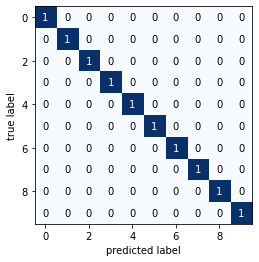

In [43]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pprint
#creating confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [44]:
print(metrics.classification_report(list_data_answers, list_data_FoundCode))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



#Dataset4-Hard

##Import Dataset

In [45]:
import pandas as pd;

#Loading dataset and renaming columns

df=pd.read_csv("FAQ_standard.csv");
df.columns=["questions","answers","AnswerCode"];

df

,questions,answers,AnswerCode
0,What does the job hunting experience look like ?,Job hunting experience involves networking to ...,1
1,Any insights you can offer about the DS job ma...,"There are many kinds of roles, data scientist,...",2
2,What's the impact of Covid on hiring for DS ro...,Hiring is going to slow down. First in small c...,3
3,What skills and qualities do employers look fo...,The following are some skills employers usuall...,4
4,Do employers look for an advanced ML degree?,For more senior roles: People typically look f...,5
5,How does a typical day of a data scientist loo...,Here are some tasks in the typical day of a da...,6
6,Is preparation of algorithms and data structur...,Yes. In many data science interviews (ML Scien...,7
7,What is the mathematical background required t...,The following three are the basic building blo...,8
8,What are the various rounds in a data scientis...,Usually the data science interview has a subse...,9
9,What level of proficiency is needed for a data...,"Needs to be reasonably proficient. Again, a da...",10


In [46]:
import pandas as pd;

#Load dataset and rename columns

df_test=pd.read_excel("FAQ_test_Hard.xlsx")
df_test.columns=["questions","ActualCode","PredictedCode","Prediction?","ActualQuestion","PredictedQuestion"]

df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How difficult is it to find a job?,1,NaN,NaN,What does the job hunting experience look like ?,NaN
1,Please provide how data science jobs are in th...,2,NaN,NaN,Any insights you can offer about the DS job ma...,NaN
2,How has the Covid impacted job?,3,NaN,NaN,What's the impact of Covid on hiring for DS ro...,NaN
3,Tell me about the skills required for Data sci...,4,NaN,NaN,What skills and qualities do employers look fo...,NaN
4,Is advanced knowledge of ML required?,5,NaN,NaN,Do employers look for an advanced ML degree?,NaN
5,What are the tasks performed by a data scienti...,6,NaN,NaN,How does a typical day of a data scientist loo...,NaN
6,How much is data structure important for data ...,7,NaN,NaN,Is preparation of algorithms and data structur...,NaN
7,How much maths knowledge is required to get a ...,8,NaN,NaN,What is the mathematical background required t...,NaN
8,How many rounds of interview is done for data ...,9,NaN,NaN,What are the various rounds in a data scientis...,NaN
9,How much coding experience is required for dat...,10,NaN,NaN,What level of proficiency is needed for a data...,NaN


##Data Preprocessing

In [47]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords


def clean_sentence(sentence, stopwords=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)

    
    if stopwords:
         sentence = remove_stopwords(sentence)
    
    
    return sentence
                    
def get_cleaned_sentences(tf,stopwords=False):    
    sents=tf[["questions"]];
    cleaned_sentences=[]

    for index,row in tf.iterrows():
        #print(index,row)
        cleaned=clean_sentence(row["questions"],stopwords);
        cleaned_sentences.append(cleaned);
    return cleaned_sentences;

cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
print(cleaned_sentences);

print("\n")

cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
print(cleaned_sentences_with_stopwords);

['job hunting experience look like', 'insights offer ds job market', 'whats impact covid hiring ds roles', 'skills qualities employers look data scientist', 'employers look advanced ml degree', 'typical day data scientist look like', 'preparation algorithms data structures needed data science interview', 'mathematical background required data scientist', 'rounds data scientist interview', 'level proficiency needed data scientist coding']


['what does the job hunting experience look like ', 'any insights you can offer about the ds job market ', 'whats the impact of covid on hiring for ds roles', 'what skills and qualities do employers look for in a data scientist', 'do employers look for an advanced ml degree', 'how does a typical day of a data scientist look like', 'is preparation of algorithms and data structures needed for a data science interview ', 'what is the mathematical background required to be a data scientist ', 'what are the various rounds in a data scientist interview ', 

In [48]:
print(cleaned_sentences_with_stopwords[0]);

what does the job hunting experience look like 


##Word2Vec-Skipgram Model

In [49]:
from gensim.models import Word2Vec 
import gensim.downloader as api

    
v2w_model=None;
try:
    v2w_model = gensim.models.KeyedVectors.load("w2vecmodel.mod")
    print("Loaded w2v model")
except:            
    v2w_model = api.load('word2vec-google-news-300')
    v2w_model.save("w2vecmodel.mod")
    print("Saved w2v model")

w2vec_embedding_size=len(v2w_model['computer']);

Loaded w2v model


In [50]:
#question_orig="What does a data scientist usually do ?"
#question_orig=input()
#question=clean_sentence(question_orig,stopwords=False);
cleaned_sentences_test=get_cleaned_sentences(df_test,stopwords=False)
print(cleaned_sentences_test);

['how difficult is it to find a job', 'please provide how data science jobs are in the market', 'how has the covid impacted job', 'tell me about the skills required for data science in the industry', 'is advanced knowledge of ml required', 'what are the tasks performed by a data scientist in a day', 'how much is data structure important for data science positions', 'how much maths knowledge is required to get a data science job', 'how many rounds of interview is done for data science roles', 'how much coding experience is required for data science positions']


In [51]:
def getWordVec(word,model):
        samp=model['computer'];
        vec=[0]*len(samp);
        try:
                vec=model[word];
        except:
                vec=[0]*len(samp);
        return (vec)


def getPhraseEmbedding(phrase,embeddingmodel):
                       
        samp=getWordVec('computer', embeddingmodel);
        vec=numpy.array([0]*len(samp));
        den=0;
        for word in phrase.split():
            #print(word)
            den=den+1;
            vec=vec+numpy.array(getWordVec(word,embeddingmodel));
        #vec=vec/den;
        #return (vec.tolist());
        return vec.reshape(1, -1)

In [52]:
#With w2Vec for original question dataset
import numpy
sent_embeddings=[];
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

In [53]:
#With w2Vec for test question dataset
import numpy
sent_embeddings_test=[];
for sent_test in cleaned_sentences_test:
    sent_embeddings_test.append(getPhraseEmbedding(sent_test,v2w_model));

In [54]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
def retrieveAndPrintFAQAnswer(question_embeddings_test,sentence_embeddings,FAQdf,sentences,FAQdf_test,sentences_test):
  for index_test,faq_embedding_test in enumerate(question_embeddings_test):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
        
      sim=cosine_similarity(faq_embedding,faq_embedding_test)[0][0];
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim;
        index_sim=index;

    FAQdf_test.iloc[index_test,2]=FAQdf.iloc[index_sim,2]
    FAQdf_test.iloc[index_test,5]=FAQdf.iloc[index_sim,0]
    print("\n")
    print("Question: ",sentences_test[index_test])
    print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    print("Answer:",FAQdf.iloc[index_sim,1])        
  df_test=FAQdf_test 
retrieveAndPrintFAQAnswer(sent_embeddings_test,sent_embeddings,df,cleaned_sentences,df_test,cleaned_sentences_test);



Question:  how difficult is it to find a job


Retrieved:  What does the job hunting experience look like ?
Answer: Job hunting experience involves networking to get in touch with the right people in various companies, applying to lots of jobs through various channels, preparing for interviews – while interviews are uncertain it is necessary to prepare well what you CAN prepare, smart scheduling of interviews to get the best job and salary you can.


Question:  please provide how data science jobs are in the market


Retrieved:  Is preparation of algorithms and data structures needed for a data science interview ?
Answer: Yes. In many data science interviews (ML Scientist, data scientist, ML Engineer, Data engineer) there is a coding round and an algorithms round. So preparing algorithms and data structures is necessary. Some of the Analyst interviews, such as a data analyst and a business analyst might not have an algorithms and data structures round.


Question:  how has the covid 

In [55]:
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How difficult is it to find a job?,1,1.0,NaN,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,Please provide how data science jobs are in th...,2,7.0,NaN,Any insights you can offer about the DS job ma...,Is preparation of algorithms and data structur...
2,How has the Covid impacted job?,3,1.0,NaN,What's the impact of Covid on hiring for DS ro...,What does the job hunting experience look like ?
3,Tell me about the skills required for Data sci...,4,7.0,NaN,What skills and qualities do employers look fo...,Is preparation of algorithms and data structur...
4,Is advanced knowledge of ML required?,5,5.0,NaN,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,What are the tasks performed by a data scienti...,6,6.0,NaN,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,How much is data structure important for data ...,7,7.0,NaN,Is preparation of algorithms and data structur...,Is preparation of algorithms and data structur...
7,How much maths knowledge is required to get a ...,8,10.0,NaN,What is the mathematical background required t...,What level of proficiency is needed for a data...
8,How many rounds of interview is done for data ...,9,7.0,NaN,What are the various rounds in a data scientis...,Is preparation of algorithms and data structur...
9,How much coding experience is required for dat...,10,7.0,NaN,What level of proficiency is needed for a data...,Is preparation of algorithms and data structur...


In [56]:
for i in range(df_test.shape[0]):
 if df_test.iloc[i,1]!=df_test.iloc[i,2]:
   df_test.iloc[i,3]='InCorrect'
 else:
   df_test.iloc[i,3]='correct'
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How difficult is it to find a job?,1,1.0,correct,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,Please provide how data science jobs are in th...,2,7.0,InCorrect,Any insights you can offer about the DS job ma...,Is preparation of algorithms and data structur...
2,How has the Covid impacted job?,3,1.0,InCorrect,What's the impact of Covid on hiring for DS ro...,What does the job hunting experience look like ?
3,Tell me about the skills required for Data sci...,4,7.0,InCorrect,What skills and qualities do employers look fo...,Is preparation of algorithms and data structur...
4,Is advanced knowledge of ML required?,5,5.0,correct,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,What are the tasks performed by a data scienti...,6,6.0,correct,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,How much is data structure important for data ...,7,7.0,correct,Is preparation of algorithms and data structur...,Is preparation of algorithms and data structur...
7,How much maths knowledge is required to get a ...,8,10.0,InCorrect,What is the mathematical background required t...,What level of proficiency is needed for a data...
8,How many rounds of interview is done for data ...,9,7.0,InCorrect,What are the various rounds in a data scientis...,Is preparation of algorithms and data structur...
9,How much coding experience is required for dat...,10,7.0,InCorrect,What level of proficiency is needed for a data...,Is preparation of algorithms and data structur...


In [57]:
list_data_answers=df_test.ActualCode.values.tolist()
list_data_FoundCode=df_test.PredictedCode.values.tolist()

In [58]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
multilabel_confusion_matrix(list_data_answers, list_data_FoundCode)
#tn, fp, fn, tp = confusion_matrix([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0, 2.0, 2.0, 10.0, 4.0, 1.0, 2.0, 1.0, 2.0, 2.0]).ravel()
#print(metrics.classification_report(list_data_answers, list_data_FoundCode))

array([[[8, 1],
        [0, 1]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[5, 4],
        [0, 1]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[8, 1],
        [1, 0]]])

In [59]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix


cm = confusion_matrix(list_data_answers, list_data_FoundCode, binary=False)

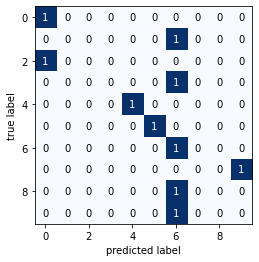

In [60]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pprint
#creating confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [61]:
print(metrics.classification_report(list_data_answers, list_data_FoundCode))

              precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       0.20      1.00      0.33         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.40        10
   macro avg       0.27      0.40      0.30        10
weighted avg       0.27      0.40      0.30        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
